In [1]:
#importing gpu
import tensorflow 
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
#checking gpu function availability 
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
#session-configuration adjusting
session = InteractiveSession(config=config)
print(tensorflow.__version__)
print(len(tensorflow.config.list_physical_devices('GPU'))>0)

C:\Users\Windows\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2.10.0
True


In [2]:
#checking gpu status
!nvidia-smi

Thu Sep 29 12:48:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.94       Driver Version: 516.94       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   55C    P2    65W / 240W |   6102MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
#importing libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Input, BatchNormalization
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import os, pickle
from os import listdir
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np
from PIL import Image
import cv2, imutils
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.optimizers import Adam
from glob import glob

In [4]:
#calling global varibles
img_width, img_height = 299, 299
#learning rate initialization
INIT_LR = 1e-3
image_size = 0
default_image_size = tuple((299, 299))
IMAGE_SIZE = [299, 299]
depth = 3
nb_train_samples = 3108  
nb_validation_samples = 774 
directory_root = 'D:/WorkSpace/Q3S6/Paddy'

In [5]:
#image directory and label fixing 
#converting image to array
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None


image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir:
        # remove .DS_Store from list
        if directory == ".DS_Store":
            root_dir.remove(directory)

    for plant_folder in root_dir:
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")

        for disease_folder in plant_disease_folder_list:
            # remove .DS_Store from list
            if disease_folder == ".DS_Store":
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")

            for single_plant_disease_image in plant_disease_image_list:
                if single_plant_disease_image == ".DS_Store":
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")
except Exception as e:
    print(f"Error : {e}")
image_size = len(image_list)
print(image_size)
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer, open('D:/WorkSpace/Q3S6/paddy_cnn_q3s6_27_9_2022.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)
print(label_binarizer.classes_)

[INFO] Loading images ...
[INFO] Processing Blast ...
[INFO] Processing FalseSmut ...
[INFO] Processing RiceBug ...
[INFO] Processing SheathRot ...
[INFO] Processing StemBorer ...
[INFO] Processing unrelated_image ...
[INFO] Processing Blast ...
[INFO] Processing FalseSmut ...
[INFO] Processing RiceBug ...
[INFO] Processing SheathRot ...
[INFO] Processing StemBorer ...
[INFO] Processing unrelated_image ...
[INFO] Image loading completed
3882
['Blast' 'FalseSmut' 'RiceBug' 'SheathRot' 'StemBorer' 'unrelated_image']


In [6]:
#localized model structure build-up 
inputShape = (img_height, img_width, depth)
#initialization of dimension change 
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, img_height, img_width)
    chanDim = 1
folders = glob('D:/WorkSpace/Q3S6/Paddy/train/*')
#input layer calling 
inputs = Input(shape=(299, 299, 3))
bboxHead = inputs
bboxHead = Conv2D(32, (3, 3), padding="same", input_shape=inputShape)(bboxHead)
bboxHead = Activation('relu')(bboxHead)
bboxHead = BatchNormalization(axis=chanDim)(bboxHead)
bboxHead = MaxPooling2D(pool_size=(3, 3))(bboxHead)
bboxHead = Dropout(0.25)(bboxHead)
bboxHead = Conv2D(64, (3, 3), padding="same")(bboxHead)
bboxHead = Activation('relu')(bboxHead)
bboxHead = BatchNormalization(axis=chanDim)(bboxHead)
bboxHead = Conv2D(64, (3, 3), padding="same")(bboxHead)
bboxHead = Activation("relu")(bboxHead)
bboxHead = BatchNormalization(axis=chanDim)(bboxHead)
bboxHead = MaxPooling2D(pool_size=(2, 2))(bboxHead)
bboxHead = Dropout(0.25)(bboxHead)
bboxHead = Conv2D(128, (3, 3), padding="same")(bboxHead)
bboxHead = Activation("relu")(bboxHead)
bboxHead = BatchNormalization(axis=chanDim)(bboxHead)
bboxHead = Conv2D(128, (3, 3), padding="same")(bboxHead)
bboxHead = Activation("relu")(bboxHead)
bboxHead = BatchNormalization(axis=chanDim)(bboxHead)
bboxHead = MaxPooling2D(pool_size=(2, 2))(bboxHead)
bboxHead = Dropout(0.25)(bboxHead)
bboxHead = Flatten()(bboxHead)
bboxHead = Dense(1024)(bboxHead)
bboxHead = Activation("relu")(bboxHead)
bboxHead = BatchNormalization()(bboxHead)
bboxHead = Dropout(0.5)(bboxHead)
bboxHead = Dense(n_classes)(bboxHead)
bboxHead = Activation("softmax")(bboxHead)
#output layer calling
model = Model(inputs, bboxHead)
model.summary()
#optimizer calling
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / epochs)
#model compiling
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 299, 299, 32)      896       
                                                                 
 activation (Activation)     (None, 299, 299, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 299, 299, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 99, 99, 32)        0     

In [11]:
#image augmentation
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    brightness_range=[0.2,1.2])
validation_datagen = ImageDataGenerator(rescale=1. / 255)
#dataset calling
train = train_datagen.flow_from_directory('D:/WorkSpace/Q3S6/Paddy/train/',
                                                    target_size=(img_width, img_height),
                                                    batch_size=32, class_mode='categorical')
validation = validation_datagen.flow_from_directory(
    'D:/WorkSpace/Q3S6/Paddy/validation/',
    target_size=(img_width, img_height),
    batch_size=32, class_mode='categorical')

Found 3108 images belonging to 6 classes.
Found 774 images belonging to 6 classes.


Epoch 1/50
98/98 [==============================] - 400s 4s/step - loss: 1.7656 - accuracy: 0.3871 - val_loss: 3.7510 - val_accuracy: 0.1667
Epoch 2/50
98/98 [==============================] - 313s 3s/step - loss: 1.5351 - accuracy: 0.4324 - val_loss: 2.1916 - val_accuracy: 0.2610
Epoch 3/50
98/98 [==============================] - 380s 4s/step - loss: 1.2972 - accuracy: 0.5045 - val_loss: 2.4302 - val_accuracy: 0.2571
Epoch 4/50
98/98 [==============================] - 322s 3s/step - loss: 1.2641 - accuracy: 0.5393 - val_loss: 1.4380 - val_accuracy: 0.5142
Epoch 5/50
98/98 [==============================] - 242s 2s/step - loss: 1.1938 - accuracy: 0.5653 - val_loss: 1.0448 - val_accuracy: 0.5995
Epoch 6/50
98/98 [==============================] - 241s 2s/step - loss: 1.0854 - accuracy: 0.5985 - val_loss: 1.6594 - val_accuracy: 0.5375
Epoch 7/50
98/98 [==============================] - 242s 2s/step - loss: 1.0270 - accuracy: 0.6178 - val_loss: 1.1805 - val_accuracy: 0.6680
Epoch 8/50
98

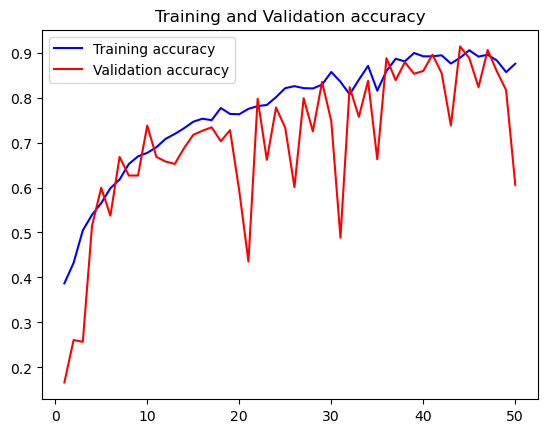

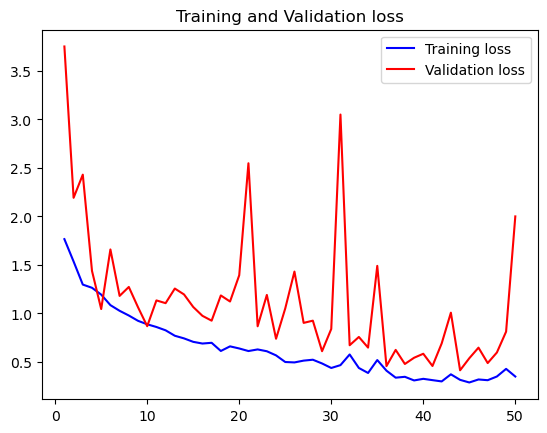

[0.3870656490325928, 0.4324324429035187, 0.5045045018196106, 0.5392535328865051, 0.565315306186676, 0.5984556078910828, 0.6177605986595154, 0.6521878838539124, 0.6692406535148621, 0.676962673664093, 0.6895109415054321, 0.7081724405288696, 0.719111979007721, 0.7316602468490601, 0.7461389899253845, 0.7528957724571228, 0.7496782541275024, 0.776705265045166, 0.7635135054588318, 0.7628700137138367, 0.7747747898101807, 0.780888020992279, 0.7834620475769043, 0.8008365631103516, 0.8207850456237793, 0.8252895474433899, 0.8207850456237793, 0.8201415538787842, 0.8285070657730103, 0.8568211197853088, 0.834942102432251, 0.80694979429245, 0.8394466042518616, 0.8703346252441406, 0.815315306186676, 0.8587515950202942, 0.8861004114151001, 0.8803088665008545, 0.8989704251289368, 0.8915701508522034, 0.8915701508522034, 0.8938223719596863, 0.8754826188087463, 0.888352632522583, 0.9050836563110352, 0.8909266591072083, 0.8951094150543213, 0.8822394013404846, 0.8564993739128113, 0.8751608729362488] [0.166666

In [13]:
#model training
history = model.fit(train,
                    steps_per_epoch=len(train),
                    epochs=50, validation_data=validation,
                    validation_steps=len(validation))
#model saving
model.save('D:/WorkSpace/Q3S6/paddy_cnn_q3s6_29_9_2022.h5')
#model status checking
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy)+1)
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()
print(accuracy, val_acc, loss, val_loss)

1/1 [==============================] - 0s 188ms/step
[[8.4366709e-01 1.1060744e-02 7.6474785e-03 1.3658223e-01 9.6782074e-05
  9.4568083e-04]]
probability:0.8436671
Blast


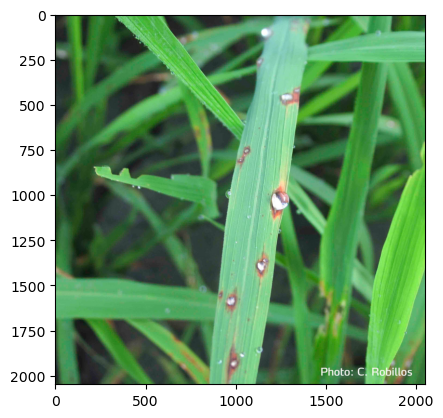

In [14]:
#model testing
loaded_model =load_model('D:/WorkSpace/Q3S6/paddy_cnn_q3s6_29_9_2022.h5')
model_disease = loaded_model
#test image calling
image_dir = "D:/WorkSpace/Q3S6/Crop images/rice_blast_233754632_1732789123577441_6836549985591341373_n.jpg"
img = plt.imread('D:/WorkSpace/Q3S6/Crop images/rice_blast_233754632_1732789123577441_6836549985591341373_n.jpg')
#image conversion to array
im = convert_image_to_array(image_dir)
#image-array to float conversion
np_image_li = np.array(im, dtype=np.float16) / 255
#image dimension adjusting
npp_image = np.expand_dims(np_image_li, axis=0)
#model prediction testing 
result = model_disease.predict(npp_image)
print(result)
#data class probability detection
itemindex = np.where(result == np.max(result))
print("probability:" + str(np.max(result)) + "\n" + label_binarizer.classes_[itemindex[1][0]])
plt.imshow(img)
plt.show()

1/1 [==============================] - 0s 79ms/step
SheathRot (0.99722)
unrelated_image (0.0027571)
[[3.1580431e-08 1.8815079e-05 1.0461392e-10 9.9722373e-01 2.5952801e-07
  2.7571500e-03]]
probability:0.99722373
SheathRot


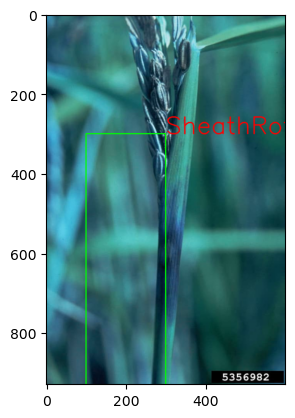

-1

In [3]:
#model validation
#importing libraries
import cv2, imutils
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
#model loading
model = load_model('D:/WorkSpace/Q3S6/paddy_cnn_q3s6_29_9_2022.h5')
#test image calling
TEST_IMAGE = 'D:/WorkSpace/Q3S6/Crop images/rice_sheath_rot180668531_3937048669664215_9159438826503454512_n.jpg'
#test image processing
img=image.load_img(TEST_IMAGE,target_size=(299, 299))
#image conversion to array
img_arr=image.img_to_array(img)
img_arr
img_arr.shape
#image-array casting conversion
img_arr=img_arr/255
#image dimension adjusting
img_arr=np.expand_dims(img_arr,axis=0)
#model prediction testing 
pred = model.predict(img_arr)
#data classes
classes = np.array(['Blast', 'FalseSmut', 'RiceBug', 'SheathRot', 'StemBorer', 'unrelated_image'])
#data class probability detection
top_2 = np.argsort(pred[0])[:-3:-1]
for i in range(2):
    print("{}".format(classes[top_2[i]])+" ({:.5})".format(pred[0][top_2[i]]))
print(pred)
itemindex = np.where(pred == np.max(pred))
print("probability:" + str(np.max(pred)) + "\n" + classes[itemindex[1][0]])
#localization parameters calling
(startX, startY, endX, endY) = pred[:, 0], pred[:, 1], pred[:, 2], pred[:, 3]
#test image calling
test_image = cv2.imread(TEST_IMAGE)
#test image resizing
test_image = imutils.resize(test_image, width=600)
#test image adjusting
(h, w) = test_image.shape[:2]
startX = int(startX * w)
startY = int(startY * h)
endX = int(endX * w)
endY = int(endY * h)
#test image localization
output = cv2.rectangle(test_image, (startX+300, startY+300), (endX+100, endY+100), (0, 255, 0), 2)
#test image localized prediction
output = cv2.putText(test_image, classes[itemindex[1][0]], (startX+300, startY+300), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 2, cv2.LINE_AA)
cv2.imshow("Output", test_image)
cv2.imwrite('D:/WorkSpace/Q3S6/result_cnn/det1.jpg', test_image)
plt.imshow(output)
plt.show()
cv2.waitKey(0)